<a href="https://colab.research.google.com/github/truongthuanr/self-project/blob/main/11_Named_Entity_Recognition/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install datasets

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import os


In [3]:
from keras.models import Model,load_model
from keras.layers import Input,Embedding,TimeDistributed,\
                         Dropout,Conv1D,MaxPooling1D,\
                         Flatten,Bidirectional,LSTM,Dense,\
                         concatenate

from keras.initializers import RandomUniform

from keras.optimizers import Adam





In [4]:
# For vetorization
max_word_tokens = 24000
max_sentence_length = 50
max_word_len = 20


# Dataset

Used dataset:

https://huggingface.co/datasets/conll2003

In [5]:
%%capture
conll_data = load_dataset("conll2003")

# Data preprocessing


## Character processing

In [6]:
char2Idx = {"PADDING":0, "UNKNOWN":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char2Idx[c] = len(char2Idx)
len(char2Idx)

95

In [7]:
def character_vectorize(X):
  data_vec = []
  for sentence in X:
    # print(f"Sentence: {sentence}")
    padchar = char2Idx['PADDING']
    sentence_vec=[]
    for word in sentence:
      # print(word)
      chars = []
      if len(word) >= max_word_len:

        chars=[char2Idx[c] for c in word[:max_word_len]]
      else:
        prepad=int((max_word_len-len(word))/2)
        postpad=max_word_len-(len(word)+prepad)
        chars.extend([padchar]*prepad)
        chars.extend([char2Idx[c] for c in word])
        chars.extend([padchar]*postpad)
      sentence_vec.append(chars)

    data_vec.append(sentence_vec)
  data_vec = np.asarray(data_vec, dtype=object)
  return data_vec



def char_preprocessing(char_input):
  '''
  input:: char_input: list of words
  output: vecterized array of character
  with shape(sentences, max_sentence_len, max_word_len)
  '''
  X_chars = character_vectorize(char_input)
  X_chars = pad_sequences(sequences = X_chars,
                          maxlen=max_sentence_length,
                          dtype=object,
                          padding="post",
                          truncating="post",
                          value=0)

  X_chars = np.asarray(X_chars,
                       dtype=np.float32)

  return X_chars

In [8]:

X_train_char = char_preprocessing(conll_data['train']['tokens'])

X_test_char = char_preprocessing(conll_data['test']['tokens'])
X_val_char = char_preprocessing(conll_data['validation']['tokens'])

## Word preprocessing

In [9]:
def word_preprocessing(word_input):
  return np.array([ " ".join(row) for row in word_input])



In [10]:
X_train_word = word_preprocessing(conll_data['train']['tokens'])
X_test_word = word_preprocessing(conll_data['test']['tokens'])
X_val_word = word_preprocessing(conll_data['validation']['tokens'])

## Caps preprocessing

In [11]:
case2id = {'allcaps':0,
           'upperinitial':1,
           'lower':2,
           'mixedcaps':3,
           'noinfo':4}
id2case = {v:k for k,v in case2id.items()}

In [12]:
def case_vectorize(input):
  '''
  input: array of sentences, sentencs is list of word
  '''
  case_vec = []

  for sentence in input:
    sen_case_type = []
    for word in sentence:
      temp = [0]*len(case2id)
      # if word is Title
      if word.istitle():
        temp[case2id['upperinitial']] =1
        sen_case_type.append(temp)

      # if uper, lower, mixed or else
      else:
        if word.isupper():
          temp[case2id['allcaps']] = 1
          sen_case_type.append(temp)
        elif word.islower():
          temp[case2id['lower']]=1
          sen_case_type.append(temp)
        else:
          if word.lower().islower():
            temp[case2id['mixedcaps']]=1
            sen_case_type.append(temp)
          else:
            temp[case2id['noinfo']]=1
            sen_case_type.append(temp)


    case_vec.append(sen_case_type)
  return case_vec



In [13]:
def case_preprocesing(X_input):
  X_case = case_vectorize(X_input)

  X_case = pad_sequences(sequences = X_case,
                        maxlen=max_sentence_length,
                        dtype=object,
                        padding="post",
                        truncating="post",
                        value=case2id['noinfo'])

  X_case = np.asarray(X_case,
                      dtype=np.float32)

  return X_case


In [14]:

X_train_case = case_preprocesing(conll_data['train']['tokens'])
X_test_case = case_preprocesing(conll_data['test']['tokens'])
X_val_case = case_preprocesing(conll_data['validation']['tokens'])

## Targer preprocessing

In [15]:
label2id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v: k for k, v in label2id.items()}


In [16]:
y_train = pad_sequences(conll_data['train']['ner_tags'],
                        dtype='int32',
                        maxlen=max_sentence_length,
                        padding='post',
                        truncating='post',
                        value=0,)

def encoding_ytrain(y_input):

  y_train = pad_sequences(y_input,
                        dtype='int32',
                        maxlen=max_sentence_length,
                        padding='post',
                        truncating='post',
                        value=0,)
  n=len(label2id)
  nrow=len(y_train)
  encoded = np.zeros(shape=(nrow,max_sentence_length,n))
  for iy, y in enumerate(y_train):
    senvec = np.zeros(shape=(max_sentence_length,n))
    for ichar, char in enumerate(y):
      charvec = np.zeros(n)
      charvec[char] = 1
      # print(f"{char=}")
      # print(f"{charvec=}")
      senvec[ichar]=charvec

    encoded[iy] = senvec
  return encoded




In [17]:
y_train = encoding_ytrain(conll_data['train']['ner_tags'])
y_test = encoding_ytrain(conll_data['test']['ner_tags'])
y_val = encoding_ytrain(conll_data['validation']['ner_tags'])

# Model

In [18]:
from keras.layers import TextVectorization

In [19]:
text_vectorizer = TextVectorization(max_tokens=max_word_tokens,   # how many word in the vocab lib
                                    standardize='lower_and_strip_punctuation', # process the tab
                                    split='whitespace', # split the token
                                    ngrams=None,
                                    output_mode='int', # map token to number
                                    output_sequence_length=max_sentence_length,
                                    pad_to_max_tokens=False,
                                    vocabulary=None,)
text_vectorizer.adapt(np.array([ " ".join(row) for row in conll_data['train']['tokens']]))

In [20]:
# Word level
word_input = Input(shape=(1,),dtype=tf.string,name='word_input')
# Tokenize

words_vectorize = text_vectorizer(word_input)

# Embedding
embedding = Embedding(input_dim=max_word_tokens,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=None)
words = embedding(words_vectorize)


In [21]:
# Character level
character_input=Input(shape=(None,max_word_len,),
                      name='char_input',
                      dtype=tf.int32)
embed_char_out=TimeDistributed(Embedding(input_dim = len(char2Idx),
                                         output_dim=10,
                                         embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                         input_length=max_sentence_length,),
                                         name='char_embedding')(character_input)
dropout = Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3,
                                   filters=10,
                                   padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_word_len))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

In [22]:
## Caps feature
casing_input = Input(shape=(max_sentence_length,), dtype='int32', name='casing_input')
casing_embed = Embedding(input_dim=len(case2id),
                        output_dim=len(case2id),
                        input_length=max_sentence_length,
                        trainable=False)

casing = casing_embed(casing_input)

In [23]:
combined = concatenate([words, char, casing])
# combined = words
# Bi-LSTM
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(combined)

# # Output -> Tag Scoring -> Tag
output = TimeDistributed(Dense(len(label2id), activation='softmax'))(output)
model = Model(inputs=[word_input, character_input, casing], outputs=[output])


In [24]:
model.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, None, 20)]           0         []                            
                                                                                                  
 char_embedding (TimeDistri  (None, None, 20, 10)         950       ['char_input[0][0]']          
 buted)                                                                                           
                                                                                                  
 dropout (Dropout)           (None, None, 20, 10)         0         ['char_embedding[1][0]']      
                                                                                                  
 time_distributed (TimeDist  (None, None, 20, 10)         310       ['dropout[1][0]']         

In [26]:
history = model.fit([X_train_word,X_train_char, X_train_case],
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=([X_val_word,X_val_char,X_val_case], y_val))

Epoch 1/100
220/220 [==============================] - 99s 395ms/step - loss: 0.0355 - accuracy: 0.9482 - val_loss: 0.0256 - val_accuracy: 0.9540
Epoch 2/100
220/220 [==============================] - 75s 343ms/step - loss: 0.0192 - accuracy: 0.9655 - val_loss: 0.0147 - val_accuracy: 0.9749
Epoch 3/100
220/220 [==============================] - 75s 342ms/step - loss: 0.0111 - accuracy: 0.9820 - val_loss: 0.0098 - val_accuracy: 0.9849
Epoch 4/100
220/220 [==============================] - 72s 328ms/step - loss: 0.0071 - accuracy: 0.9890 - val_loss: 0.0084 - val_accuracy: 0.9871
Epoch 5/100
220/220 [==============================] - 74s 337ms/step - loss: 0.0052 - accuracy: 0.9923 - val_loss: 0.0081 - val_accuracy: 0.9872
Epoch 6/100
220/220 [==============================] - 73s 332ms/step - loss: 0.0040 - accuracy: 0.9940 - val_loss: 0.0082 - val_accuracy: 0.9875
Epoch 7/100
220/220 [==============================] - 73s 331ms/step - loss: 0.0031 - accuracy: 0.9953 - val_loss: 0.0079 -

In [28]:
model.save('bilstm-cnn.keras')

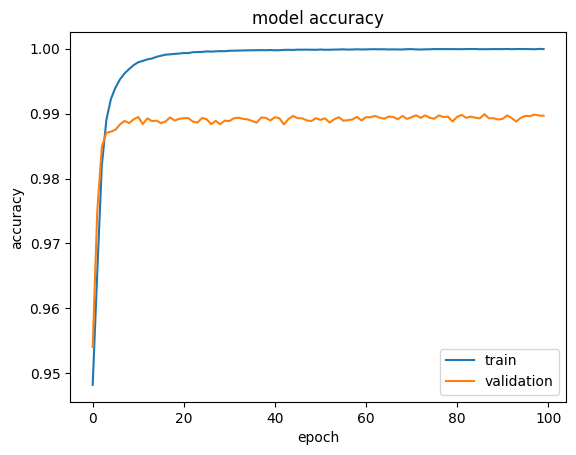

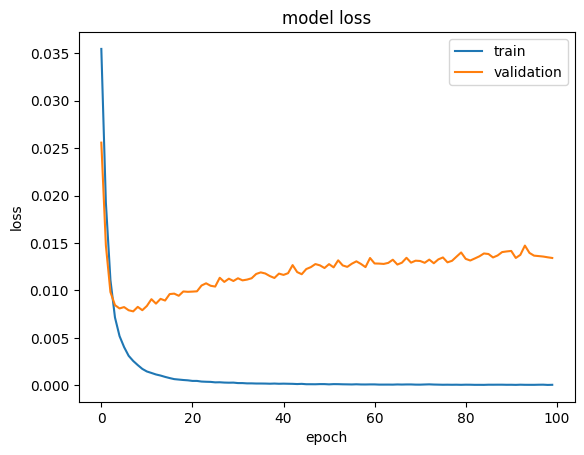

In [45]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Predictions

In [7]:
%%capture
!wget https://github.com/truongthuanr/self-project/raw/main/11_Named_Entity_Recognition/bilstm-cnn.keras

In [29]:
loaded_model = load_model('bilstm-cnn.keras')

In [30]:
def make_prediction(model, input_string):
  X_words = np.asarray([input_string])
  X_input_list = [input_string.split()]
  X_chars = char_preprocessing(X_input_list)
  X_case = case_preprocesing(X_input_list)
  predictions = model.predict([X_words,X_chars,X_case])


  # predictions = np.argmax()

  return predictions

In [31]:
example = "Connie Palmer's cat Ralphie was way, way up in a tree in the family's backyard in Ohio"
predictions = make_prediction(loaded_model, example)

1/1 [==============================] - 1s 564ms/step


In [32]:
temp = np.squeeze(np.argmax(predictions,axis=2))
temp = [id2label[word] for word in temp]
print("".join([f"{word:10}" for word in example.split()]))
print("".join([f"{word:10}" for word in temp[:len(example.split())]]))


Connie    Palmer's  cat       Ralphie   was       way,      way       up        in        a         tree      in        the       family's  backyard  in        Ohio      
B-PER     I-PER     O         B-LOC     O         O         O         O         O         O         O         O         O         O         O         O         B-LOC     


# Test - F1 Score metrics

In [33]:
np.set_printoptions(suppress=True,linewidth=90)


In [34]:
test_predictions = loaded_model.predict([X_test_word,X_test_char, X_test_case])

108/108 [==============================] - 3s 30ms/step


In [35]:
np.squeeze(np.argmax(test_predictions,axis=2))[0]

array([0, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
test_predictions[0][2]

array([0.00000028, 0.00000193, 0.        , 0.00009726, 0.        , 0.99977416,
       0.        , 0.00012634, 0.        ], dtype=float32)

In [37]:
def compute_f1score(prediction, actual):
  prediction = np.squeeze(np.argmax(prediction,axis=2))
  actual = np.squeeze(np.argmax(actual,axis=2))

  # count_arr[predict-label][actual-label]
  count_arr = np.zeros([len(label2id),len(label2id)])
  for rownum in range(actual.shape[0]):
    for wordnum in range(actual.shape[1]):
      pred_label = prediction[rownum][wordnum]
      actual_label = actual[rownum][wordnum]
      count_arr[pred_label][actual_label] += 1

  precision = [count_arr[i][i]/(np.sum(count_arr,axis=1))[i] for i in range(len(label2id))]
  recall = [count_arr[i][i]/(np.sum(count_arr,axis=0))[i] for i in range(len(label2id))]
  f1score = [2*recall[i]*precision[i]/(recall[i]+precision[i]) for i in range(len(label2id))]





  return count_arr,precision,recall,f1score

In [38]:
countarr,precision,recall,f1score = compute_f1score(test_predictions,y_test)
countarr

array([[164143.,     96.,     10.,     96.,     72.,     28.,     13.,     54.,     28.],
       [    47.,   1044.,     19.,     60.,      5.,     25.,      0.,      6.,      2.],
       [    22.,     15.,    881.,      1.,     18.,      2.,      9.,      0.,      5.],
       [    87.,    247.,      2.,   1205.,     26.,    114.,      1.,     56.,      3.],
       [   119.,      7.,    166.,     29.,    625.,      4.,     32.,      3.,     18.],
       [    73.,    113.,      2.,    196.,      8.,   1422.,      7.,     46.,      2.],
       [    15.,      2.,     22.,      2.,     54.,      6.,    185.,      0.,      9.],
       [    75.,     52.,      0.,     69.,      7.,     55.,      0.,    526.,     13.],
       [    65.,      4.,      9.,      0.,     12.,      0.,      8.,     10.,    136.]])

In [39]:
f1score

[0.9972659833650276,
 0.7489239598278337,
 0.8536821705426356,
 0.7090320682553692,
 0.6830601092896175,
 0.806808510638298,
 0.6727272727272727,
 0.7022696929238986,
 0.591304347826087]

0.7516749017106711

# References

https://keras.io/examples/nlp/ner_transformers/